In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM, Flatw0waCDM
from openpyxl.styles.fills import fills
from reportlab.graphics.renderPM import drawToPIL

from wowadis_muilt import run_cosmological_distances_multiprocessing,dh_inmpc,bao_dv_distance,bao_dv_dr,bao_fap,sne_luminosity_distance,log_likelihood, dm_inmpc,sne_distmod, run_lcdm_om0_by_multiprocessing,run_lcdm_methods_om0_by_multiprocessing, run_gaussian_methods_om0_by_multiprocessing, calculate_om0_distributions, run_mcmc
from scipy.optimize import minimize
import emcee
import matplotlib.pyplot as plt
import corner
import pandas as pd
from scipy.spatial import KDTree
import astropy.units as u
from scipy.stats import gaussian_kde
import gzip

data = np.genfromtxt('data/DES-SN5YR_HD.csv',
                     delimiter=',', names=True, dtype=None, encoding='utf-8')
zHEL_array = data['zHEL']
MUERR_FINAL_array = data['MUERR_FINAL']

with gzip.open('data/STAT+SYS.txt.gz', 'rt') as f:
    data = np.loadtxt(f, skiprows=1)
print("Data shape before reshape:", data.shape)

C_SYS = data.reshape((1829, 1829))
print("C_SYS shape after reshape:", C_SYS.shape)
cov_matrix_sne = np.diag(MUERR_FINAL_array ** 2) + C_SYS


print(zHEL_array)
print(MUERR_FINAL_array)
z_desy5 = np.array(zHEL_array)
des_sne_cosmo_wowa = Flatw0waCDM(H0=70, Om0=0.495, w0=-0.36, wa=-8.8)
distmod_error_desy5 = np.array(MUERR_FINAL_array)
#sne_distmod
des_distmod_compare_desy5 = sne_distmod(z=z_desy5, H0=70, Om0=0.495, w0=-0.36, wa=-8.8, cosmo=des_sne_cosmo_wowa)
# from paper:
zeff = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
dm_rd = np.array([0, 13.62, 16.85, 21.71, 27.79, 0, 39.71])
delta_dm_rd = np.array([0, 0.25, 0.32, 0.28, 0.69, 0, 0.94])
dh_rd = np.array([0, 20.98, 20.08, 17.88, 13.82, 0, 8.52])
delta_dh_rd =np.array( [0, 0.61, 0.60, 0.35, 0.42, 0, 0.17])
dv_rd =np.array([7.93, -0.445, -0.420, -0.389, -0.444, 26.07, -0.447])
delata_dv_rd = [0.15, None, None, None, None, 0.67,None]
rdrag = 147.18 * u.Mpc
coefficient_r= np.array([np.nan, -0.445, -0.420, -0.389, -0.444, np.nan, -0.447])
#few definition for calculation both the error bar of BAO DV&FAP and also draw the plot
def delta_ab(delta_a, delta_b, r):
    _delta_a= np.nan_to_num(delta_a, nan=0.0)
    _delta_b= np.nan_to_num(delta_b, nan=0.0)
    _r= np.nan_to_num(np.array(r), nan=0.0)
    return _r*_delta_a*_delta_b

def from_data_to_dvmet(z,dm_rd,dh_rd):
    dm_rd = np.array(dm_rd)
    dh_rd = np.array(dh_rd)
    z = np.array(z)
    dm = dm_rd
    dh = dh_rd
    dv = ((dm ** 2) * dh * (z)) ** (1 / 3)
    return dv

def from_data_to_fap(z,dm_rd,dh_rd):
    dm = dm_rd * 147.18
    dh = dh_rd * 147.18
    fap = (dm / dh) 
    return fap

def delta_DV(z, delta_DM, delta_DH, DM, DH, coefficient):
    #DV = ((DM ** 2) * DH * (z)) ** (1 / 3)
    partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
    partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))
    _partial_DM = np.nan_to_num(partial_DM, nan=0.0)
    _partial_DH = np.nan_to_num(partial_DH, nan=0.0)
    _delta_DM = np.nan_to_num(delta_DM, nan=0.0)
    _delta_DH = np.nan_to_num(delta_DH, nan=0.0)
    covariance_term = delta_ab(_partial_DM* _delta_DM, _partial_DH * _delta_DH, coefficient)

    sigma_DV = np.sqrt((partial_DM * delta_DM)**2 + (partial_DH * delta_DH)**2+ 2 * covariance_term)
    return sigma_DV

def delta_FAP(delta_DM, delta_DH, DM, DH, coefficient):
    FAP = (DM / DH)
    coefficient = np.nan_to_num(coefficient, nan=0.0)
    
    covariance_term = delta_ab((delta_DM / DH), (DM * delta_DH / (DH**2)), coefficient)

    sigma_FAP = np.sqrt((delta_DM / DH)**2 + ((DM * delta_DH) / (DH**2))**2 - 2* covariance_term)
    return sigma_FAP

dv = from_data_to_dvmet(zeff,dm_rd,dh_rd)
print('dv',dv)

delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r)
print('delta dv',delta_DV(zeff, delta_dm_rd, delta_dh_rd, dm_rd, dh_rd, coefficient_r))

zeff_array = np.array([0.295, 0.510, 0.706, 0.930, 1.317, 1.491, 2.330])
_compare_cosmo_bao = FlatLambdaCDM(H0=70, Om0=0.3)
_dv_dr_compare = bao_dv_dr(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0)

_dh_dr_compare  = dh_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18
_dm_dr_compare  = dm_inmpc(zeff_array, H0=70, Om0=0.3, w0=-1.0, wa=0).value/147.18

print(((_dh_dr_compare)*((_dm_dr_compare**2)*zeff_array))**(1/3))
print(_dv_dr_compare)
delta_dv_imcom = delta_DV(zeff, delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_dv_imcom) #incomplete
delta_dv = delta_dv_imcom
delta_dv[0] = 0.15  #same as in table1 of desi paper
delta_dv[5] = 0.67
print(delta_dv)
zeff_fap = np.delete(zeff_array, [0, 5])
_fap_compare = bao_fap(zeff_fap, H0=70, Om0=0.3, w0=-1.0, wa=0)
print(_fap_compare)
#(delta_DM, delta_DH, DM, DH)
delta_fap_imcom = delta_FAP(delta_dm_rd, delta_dh_rd, _dm_dr_compare, _dh_dr_compare, coefficient_r)
print(delta_fap_imcom)
delta_fap = np.delete(delta_fap_imcom, [0, 5])
print(delta_fap)
#bao part:
print(zeff_array)
print(delta_dv)

print('zeff_fap',zeff_fap)
print(delta_fap)

#SNe part:
print(z_desy5)
print(distmod_error_desy5)

print('xxxxxxxxxxxxX')

file_path = 'data/fw0wacdm_SN_emcee.txt'
data_SN = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
data_SN.columns = ['omega_m', 'w', 'wa', 'prior', 'post']
data_subset_SN = data_SN[['w', 'wa', 'omega_m']]
param_combinations_desy5 = data_subset_SN.to_numpy()

H0_column_sn_desy5 = np.full((param_combinations_desy5.shape[0], 1), 70.0)

param_combinations_desy5 = np.hstack((param_combinations_desy5,H0_column_sn_desy5))

if len(param_combinations_desy5) >= 20000:
    # Randomly select 20,000 rows
    random_indices = np.random.choice(param_combinations_desy5.shape[0], 4000, replace=False)
    lw_params = param_combinations_desy5[random_indices]

file_path_2 = 'data/fw0wacdm_planck+SN+eBOSS+3x2pt.txt'
data_sn_bao_cmb = pd.read_csv(file_path_2, sep='\s+', comment='#', header=None)
column_names_bao_cmb = [
    'omega_m', 'h0', 'omega_b', 'n_s', 'a_s', 'w', 'wa', 'mnu', 'tau',
    'shear_calibration_m1', 'shear_calibration_m2', 'shear_calibration_m3', 'shear_calibration_m4',
    'wl_photoz_bias_1', 'wl_photoz_bias_2', 'wl_photoz_bias_3', 'wl_photoz_bias_4',
    'lens_photoz_bias_1', 'lens_photoz_bias_2', 'lens_photoz_bias_3', 'lens_photoz_bias_4',
    'lens_photoz_width_1', 'lens_photoz_width_2', 'lens_photoz_width_3', 'lens_photoz_width_4',
    'bias_lens_b1', 'bias_lens_b2', 'bias_lens_b3', 'bias_lens_b4',
    'intrinsic_alignment_a1', 'intrinsic_alignment_a2', 'intrinsic_alignment_alpha1', 'intrinsic_alignment_alpha2',
    'intrinsic_alignment_bias_ta', 'prior', 'like', 'post', 'weight'
]
data_sn_bao_cmb.columns = column_names_bao_cmb
data_sn_bao_cmb = data_sn_bao_cmb[['w', 'wa', 'omega_m','h0']]
data_sn_bao_cmb['h0'] = data_sn_bao_cmb['h0'] * 100
param_combinations_sn_bao_cmb = data_sn_bao_cmb.to_numpy()

random_indices_sbc = np.random.choice(param_combinations_sn_bao_cmb.shape[0], 10000, replace=False)
lw_params_sn_bao_cmb = param_combinations_sn_bao_cmb[random_indices_sbc]

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}
#cov_matrix_sne

Data shape before reshape: (3345241,)
C_SYS shape after reshape: (1829, 1829)
[0.24651 0.336   0.38388 ... 0.02561 0.02448 0.092  ]
[0.0968 0.136  0.2332 ... 0.1237 0.116  0.2873]
dv [ 0.         12.56733789 15.90704123 19.86354247 24.13368485  0.
 31.51604873]
delta dv [       nan 0.14769734 0.19712699 0.1695468  0.36418021        nan
 0.44508433]
[ 7.78277361 12.43113123 15.97929259 19.34675898 23.81612642 25.39850208
 30.66427324]
[ 7.83003238 12.50661589 16.0763225  19.46423691 23.96074337 25.55272757
 30.8504737 ]
[0.         0.14870767 0.19699585 0.16942324 0.36576218 0.
 0.45039171]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
[0.59053747 0.87174805 1.235266   1.97072542 4.5056629 ]
[0.         0.02361165 0.03654867 0.03482655 0.09344398 0.
 0.17147831]
[0.02361165 0.03654867 0.03482655 0.09344398 0.17147831]
[0.295 0.51  0.706 0.93  1.317 1.491 2.33 ]
[0.15       0.14870767 0.19699585 0.16942324 0.36576218 0.67
 0.45039171]
zeff_fap [0.51  0.706 0.9

/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_28596/879203862.py:72: RuntimeWarning: invalid value encountered in divide
  partial_DM = (2 * DM * DH * z) / (3 * (DM**2 * DH * z)**(2/3))
/var/folders/2d/zqs_vr2n65q9fsqw5kq8wmqw0000gn/T/ipykernel_28596/879203862.py:73: RuntimeWarning: invalid value encountered in divide
  partial_DH = (DM**2 * z) / (3 * (DM**2 * DH * z)**(2/3))


In [2]:
C_inv = np.linalg.inv(cov_matrix_sne)

C = np.sum(C_inv)
C

59255.035090184116

In [3]:
des_sne_cosmo_wowachose = Flatw0waCDM(H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
des_distmod_compare_desy5_wowachose = sne_distmod(z=z_desy5, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05,cosmo=des_sne_cosmo_wowachose)

dv_dr_compare_wowachose = bao_dv_dr(zeff_array, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
fap_compare_wowachose = bao_fap(zeff_fap, H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05)
z_bao_w0wa_wowachose = {'dv': zeff_array, 'fap': zeff_fap}
data_obs_bao_wowachose = {'dv': dv_dr_compare_wowachose, 'fap': fap_compare_wowachose}
data_err_bao_wowachose = {'dv': delta_dv, 'fap': delta_fap}

z_all = {'sne': z_desy5, 'dv': zeff_array, 'fap': zeff_fap}
data_obs_all = {'sne': des_distmod_compare_desy5_wowachose, 'dv': dv_dr_compare_wowachose, 'fap': fap_compare_wowachose}
data_err_all = {'sne': distmod_error_desy5, 'dv': delta_dv, 'fap': delta_fap}

z_bao = {'dv': zeff_array, 'fap': zeff_fap}
data_obs_bao = {'dv': dv_dr_compare_wowachose, 'fap': fap_compare_wowachose}
data_err_bao = {'dv': delta_dv, 'fap': delta_fap}

In [5]:
initial_guess_bao_combine = [0.3, 70]

from wowadis_muilt_ombh2_gaussian_withcovmat import run_mcmc_with_cov as run_mcmc_with_cov_ombh2

samples_bao_combined = run_mcmc_with_cov_ombh2(z=z_bao, data_obs=data_obs_bao, data_err=data_err_bao, type='combined_distmod_lcdm_with_H0',
                                initial_guess=initial_guess_bao_combine, ndim=2, nwalkers=120, nsteps=12000, nburn=2000,
                                nthin=15)


100%|██████████| 12000/12000 [03:26<00:00, 58.02it/s]


In [6]:
np.save('data/samples_bao_combined_correct_ombh2.npy', samples_bao_combined)

Text(0.5, 1.02, 'BAO, true w0wa: H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05')

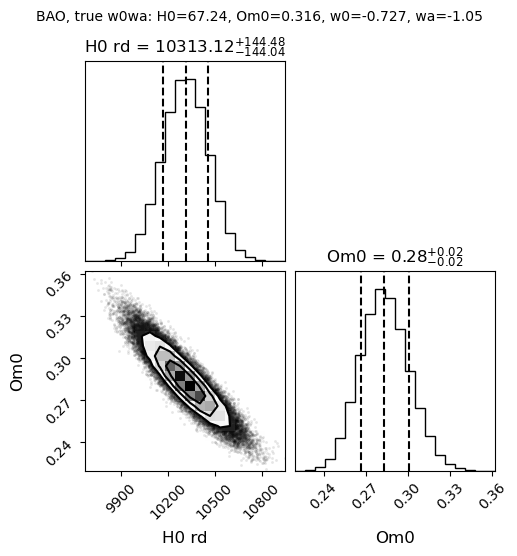

In [7]:
def rdrag_desy(Om0, H0):
    r_d = 147.05 * u.Mpc
    N_eff= 3.04
    h= H0/100
    omega_b_h2_mean = 0.02218
    omega_b_h2_sigma = 0.00055
    omega_b_h2 = np.random.normal(omega_b_h2_mean, omega_b_h2_sigma)
    omega_m_h2 = Om0 *h**2
    r_drag = r_d * (omega_m_h2 / 0.1432) ** (-0.23) * (N_eff / 3.04) ** (-0.1) * (omega_b_h2 / 0.02236) ** (-0.13)
    return r_drag


_samples_bao_combined = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$","$H_0$"])

def change_omm_to_ommh2(samples):
    # Calculate h
    samples["$H_0$$r_d$"] = samples["$H_0$"] * rdrag_desy(samples["$\Omega_m$"], samples["$H_0$"])
    columns_order = ["$H_0$$r_d$"] + [col for col in samples.columns if col not in ["$H_0$$r_d$"]]
    samples = samples[columns_order]

    samples = samples.drop(columns=["$H_0$"])

    return samples

_samples_bao_combined= change_omm_to_ommh2(_samples_bao_combined)
figure4 = corner.corner(_samples_bao_combined, labels=["H0 rd", 'Om0'],
                        show_titles=True, title_kwargs={"fontsize": 12},
                        quantiles=[0.16, 0.5, 0.84], label_kwargs={"fontsize": 12},
                        plot_datapoints=True, plot_density=True)
figure4.suptitle("BAO, true w0wa: H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05", fontsize=10, y=1.02,)



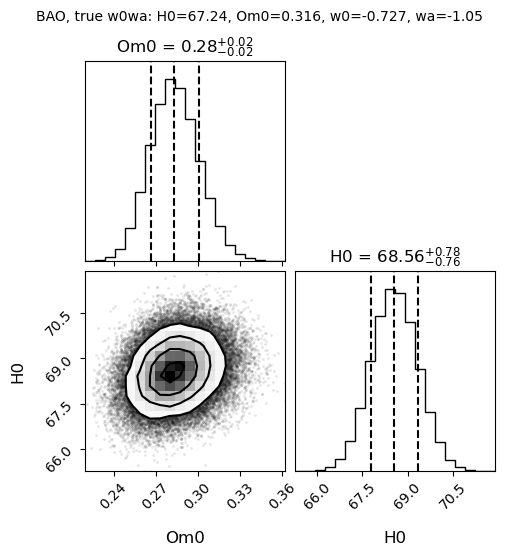

In [8]:
figure4 = corner.corner(samples_bao_combined, labels=["Om0", 'H0'],
                        show_titles=True, title_kwargs={"fontsize": 12},
                        quantiles=[0.16, 0.5, 0.84], label_kwargs={"fontsize": 12},
                        plot_datapoints=True, plot_density=True)
figure4.suptitle("BAO, true w0wa: H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05", fontsize=10, y=1.02,)

plt.show()

In [ ]:
import pickle
import numpy as np

#with open('samples_bao_combined_correct_ombh2.npy', 'rb') as f:
 #   samples_bao_combined = np.load(f)

In [ ]:
from cmb_likelihood_cal_with_sne_cov_gaussian_ombh2 import run_mcmc_only_cmb as run_mcmc_only_cmb_gaussian_omb2
from cmb_v1 import la_rzs_from_cosmoparams as fixed_la_rzs_from_cosmoparams
# H0=67.24, Om0=0.316, w0=-0.727, wa=-1.05
initial_guess_all_with_H0 = [0.3, 70]
data_cmb = fixed_la_rzs_from_cosmoparams(H0=67.24, omegam=0.316, w=-0.727, wa=-1.05)

cmbonly = run_mcmc_only_cmb_gaussian_omb2(data_cmb, initial_guess_all_with_H0, type='combined_distmod_lcdm_with_H0', ndim=2, nwalkers=250,
                            nsteps=8000, nburn=800, nthin=15)


Text(0.5, 1.04, 'CMB, truth H0=67.24, omegam=0.316, w=-0.727, wa=-1.05\n')

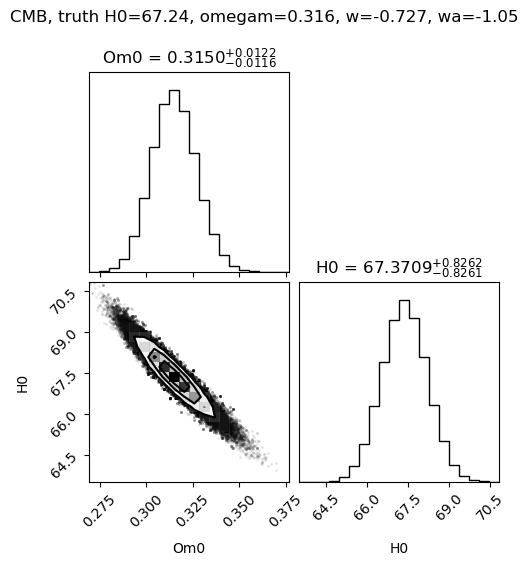

In [13]:
figure = corner.corner(cmbonly, labels=["Om0", 'H0'], show_titles=True, title_kwargs={"fontsize": 12}, title_fmt="0.4f")

figure.suptitle("CMB, truth H0=67.24, omegam=0.316, w=-0.727, wa=-1.05\n", fontsize=12, y=1.04)

In [33]:
np.save('data/cmbonly_new_figure1.npy', cmbonly)


In [7]:
import numpy as np

# Open the file in read mode
with open('data/cmbonly_new_figure1.npy', 'rb') as f:
    cmbonly = np.load(f)

with open('data/samples_bao_combined_correct_ombh2.npy', 'rb') as f:
    samples_bao_combined = np.load(f)
# Print the results
print(cmbonly)

[[ 0.31479359 66.86434468]
 [ 0.32961648 66.54200506]
 [ 0.31838378 67.08516617]
 ...
 [ 0.31714308 67.44671594]
 [ 0.31171817 67.99024865]
 [ 0.29757942 68.53804805]]


Parameter $H_0$ in chain SNe like is not constrained


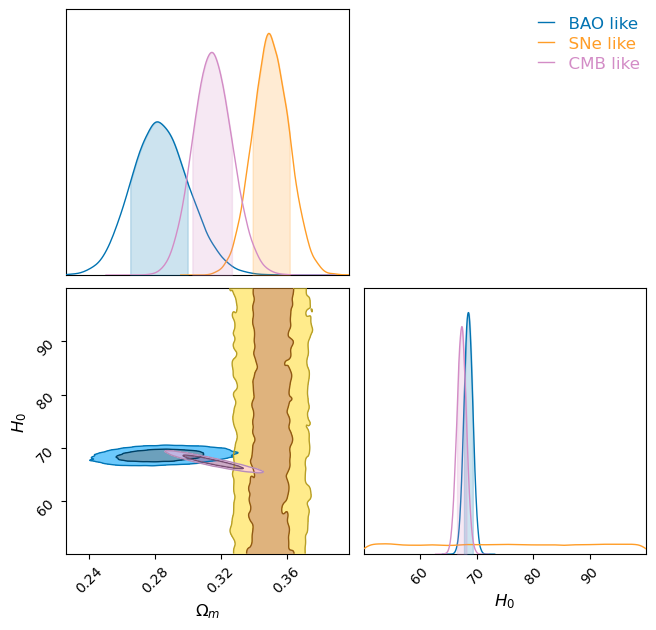

In [8]:
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig, make_sample
import matplotlib.pyplot as plt
import pickle

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)

# Convert your sample arrays to DataFrames
samples_bao_combined_df = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$", "$H_0$"])
samples_sne_combined_df = pd.DataFrame(samples_sne_combined_with_cov, columns=["$\Omega_m$", "$H_0$","M"]).drop(columns=["M"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])
#samples_sne_combined_df["$H_0$"] = np.random.uniform(50, 100, size=len(samples_sne_combined_df))

# Create the ChainConsumer instance
c = ChainConsumer()

# Add chains with both samples and name
c.add_chain(Chain(samples=samples_bao_combined_df, name="BAO like",color='#0173b2'))
c.add_chain(Chain(samples=samples_sne_combined_df, name="SNe like", color = '#ff9d27'))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like", color = '#d38cc6'))

# Configure and plot for each chain
plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=True,
    shade=True,
    bar_shade=True,
    sigmas=[1, 2],
)
c.set_plot_config(plot_config)

# Plot and add titles for clarity
fig = c.plotter.plot(figsize="column")
#fig.suptitle("Combined Chains: BAO, SNe, and CMB\nTruth H0=67.24, Omega_m=0.316, w0=-0.727, wa=-1.05", fontsize=12, y=1.04)
fig.savefig('bestw0wa_to_lcdm.png',dpi=500)
plt.show()

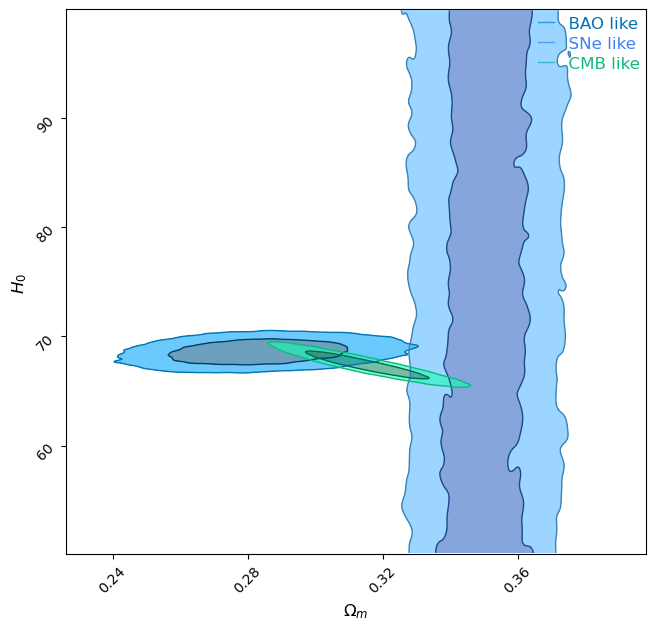

In [9]:
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig, make_sample
import matplotlib.pyplot as plt

import pickle

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)
    
# Convert your sample arrays to DataFrames
samples_bao_combined_df = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$", "$H_0$"])
samples_sne_combined_df = pd.DataFrame(samples_sne_combined_with_cov, columns=["$\Omega_m$", "$H_0$","M"]).drop(columns=["M"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])
#samples_sne_combined_df["$H_0$"] = np.random.uniform(50, 100, size=len(samples_sne_combined_df))

# Create the ChainConsumer instance
c = ChainConsumer()

# Add chains with both samples and name
c.add_chain(Chain(samples=samples_bao_combined_df, name="BAO like",color='#0173b2'))
c.add_chain(Chain(samples=samples_sne_combined_df, name="SNe like"))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like"))

# Configure and plot for each chain
plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=False,
    shade=True,
    bar_shade=True,
    sigmas=[1, 2],
)
c.set_plot_config(plot_config)

# Plot and add titles for clarity
fig = c.plotter.plot(figsize="column")
#fig.suptitle("Combined Chains: BAO, SNe, and CMB\nTruth H0=67.24, Omega_m=0.316, w0=-0.727, wa=-1.05", fontsize=12, y=1.04)
fig.savefig('bestw0wa_to_lcdm.png',dpi=500)
plt.show()

In [10]:
print(c.analysis.get_latex_table())


Parameter $H_0$ in chain SNe like is not constrained


\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccc}
        \hline
		Model & $\Omega_m$ & $H_0$ \\ 
		\hline
		BAO like & $0.281^{+0.019}_{-0.016}$ & $68.59^{+0.75}_{-0.81}$ \\ 
		SNe like & $0.350^{+0.012}_{-0.010}$ &  \\ 
		CMB like & $0.315\pm 0.012$ & $67.43^{+0.78}_{-0.89}$ \\ 
		\hline
    \end{tabular}
\end{table}


In [11]:
import numpy as np
from scipy.stats import chi2
def calculate_p_for_the_same_omm(omm_min_sne, omm_std_sne, omm_min_bao, omm_std_bao, omm_min_cmb, omm_std_cmb):
    weights_single = 1 / np.array([omm_std_sne**2, omm_std_bao**2, omm_std_cmb**2])
    omm_common_single = np.sum(np.array([omm_min_sne, omm_min_bao, omm_min_cmb]) * weights_single) / np.sum(weights_single)

    chi_squared_single = ((omm_min_sne - omm_common_single)**2 / omm_std_sne**2 +
                          (omm_min_bao - omm_common_single)**2 / omm_std_bao**2 +
                          (omm_min_cmb - omm_common_single)**2 / omm_std_cmb**2)
    dof = 2
    p_value_single = 1 - chi2.cdf(chi_squared_single, dof)
   # chis=chi2.cdf(chi_squared_single, dof)
    #p_consistent = 1 - p_value_single

    return p_value_single
a=calculate_p_for_the_same_omm(omm_min_sne=0.353, omm_std_sne=0.017, omm_min_bao=0.295, omm_std_bao=0.015, omm_min_cmb=0.315, omm_std_cmb=0.007)

p_from_best_fit=calculate_p_for_the_same_omm(omm_min_sne=0.3503,omm_std_sne= 0.011, omm_min_bao=0.281,omm_std_bao= 0.018, omm_min_cmb=0.315, omm_std_cmb=0.012)

p_from_null = calculate_p_for_the_same_omm(omm_min_sne=0.310, omm_std_sne=0.011, omm_min_bao=0.311, omm_std_bao=0.019, omm_min_cmb=0.310, omm_std_cmb=0.012)

p_from_desi_fs = calculate_p_for_the_same_omm(omm_min_sne=0.353, omm_std_sne=0.017, omm_min_bao=0.2962, omm_std_bao=0.0095, omm_min_cmb=0.315, omm_std_cmb=0.007)
p_from_best_fit,a,p_from_null,p_from_desi_fs

(0.0025301600534604063,
 0.0349054638642331,
 0.998829042533586,
 0.012626558706825719)

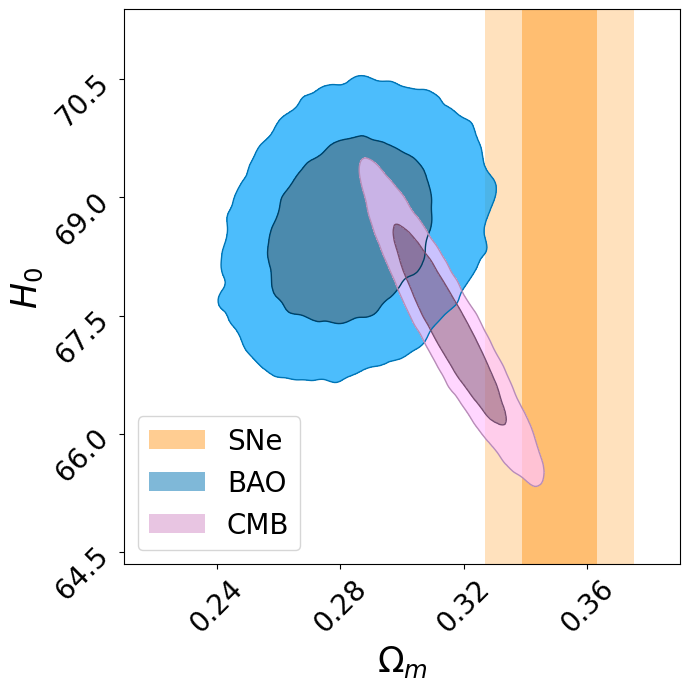

In [13]:
import numpy as np
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

samples_bao_combined_df = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$", "$H_0$"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])

c = ChainConsumer()

c.add_chain(Chain(samples=samples_bao_combined_df, name="BAO like",color='#0173b2'))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like",color='#d38cc6'))

plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=False,
    shade=True,
    bar_shade=True,
    sigmas=[1, 2],
)
c.set_plot_config(plot_config)

# Plot and get the axes
fig = c.plotter.plot(figsize="column")
ax = fig.get_axes()[0]  # Get the main axis

# Define SNe constraints for Omega_m with 1-sigma and 2-sigma bounds
omega_m_sne_mean = 0.351
omega_m_sne_err = 0.012
omega_m_1sigma_min = omega_m_sne_mean - omega_m_sne_err
omega_m_1sigma_max = omega_m_sne_mean + omega_m_sne_err
omega_m_2sigma_min = omega_m_sne_mean - 2 * omega_m_sne_err
omega_m_2sigma_max = omega_m_sne_mean + 2 * omega_m_sne_err

h0_min, h0_max = ax.get_ylim()

rect_2sigma = Rectangle(
    (omega_m_2sigma_min, h0_min),
    omega_m_2sigma_max - omega_m_2sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.3,  # Lighter alpha for 2-sigma region
    edgecolor='none'
)
ax.add_patch(rect_2sigma)

rect_1sigma = Rectangle(
    (omega_m_1sigma_min, h0_min),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='SNe',
    edgecolor='none'
)

rect_333sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#0072B2',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='BAO',
    edgecolor='none'
)
rect_444sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#d38cc6',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='CMB',
    edgecolor='none'
)
ax.add_patch(rect_1sigma)
ax.add_patch(rect_333sigma)
ax.add_patch(rect_444sigma)

ax.set_xlim(0.21, 0.39)

ax.legend(loc='lower left', fontsize=20)

ax.set_xlabel("$\Omega_m$", fontsize=25)
ax.set_ylabel("$H_0$", fontsize=25)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(False)
#fig.savefig('bestw0wa_to_lcdm.png', dpi=500)

ax.grid(False)

plt.tight_layout()
#fig.savefig('bestw0wa_to_lcdm.png', dpi=500)
plt.show()


In [14]:
import pickle

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)

samples_sne_combined_with_cov

array([[ 0.35657494, 62.38163957, -0.17512716],
       [ 0.35073623, 74.58486494,  0.20501083],
       [ 0.35819633, 85.24290444,  0.50109785],
       ...,
       [ 0.33260244, 83.12118274,  0.42640773],
       [ 0.35289176, 74.59191339,  0.20125305],
       [ 0.3707523 , 56.12814953, -0.39592262]])

In [15]:
import pickle

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)
    
samples_first_column = samples_sne_combined_with_cov[:, 0]

mean_value = np.mean(samples_first_column)
one_sigma_lower, one_sigma_upper = np.percentile(samples_first_column, [16, 84])

two_sigma_lower, two_sigma_upper = np.percentile(samples_first_column, [2.5, 97.5])

print(f"Mean: {mean_value}")
print(f"1σ bounds: {one_sigma_lower}, {one_sigma_upper}")
print(f"2σ bounds: {two_sigma_lower}, {two_sigma_upper}")


Mean: 0.350528813281409
1σ bounds: 0.33939050245512237, 0.36163212742318085
2σ bounds: 0.3287467419957864, 0.37286213256067763


In [16]:
import pickle

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)
    
with open('data/cmbonly_new_figure1.npy', 'rb') as f:
    cmbonly = np.load(f)
    
with open('data/samples_bao_combined_correct_ombh2.npy', 'rb') as f:
    samples_bao_combined = np.load(f)


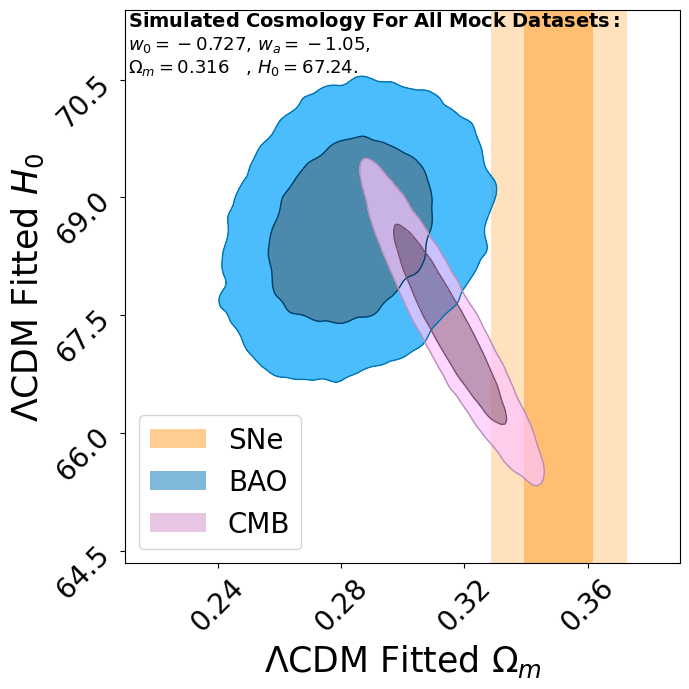

In [17]:
    
import numpy as np
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

samples_bao_combined_df = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$", "$H_0$"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])

c = ChainConsumer()

c.add_chain(Chain(samples=samples_bao_combined_df, name="BAO like",color='#0173b2'))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like",color='#d38cc6'))

plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=False,
    shade=True,
    bar_shade=True,
    sigmas=[0, 1],
)
c.set_plot_config(plot_config)

# Plot and get the axes
fig = c.plotter.plot(figsize="column")
ax = fig.get_axes()[0]  # Get the main axis

# Define SNe constraints for Omega_m with 1-sigma and 2-sigma bounds
omega_m_sne_mean = mean_value
#omega_m_sne_err = 0.012
omega_m_1sigma_min = one_sigma_lower
omega_m_1sigma_max = one_sigma_upper
omega_m_2sigma_min = two_sigma_lower
omega_m_2sigma_max = two_sigma_upper

h0_min, h0_max = ax.get_ylim()

rect_2sigma = Rectangle(
    (omega_m_2sigma_min, h0_min),
    omega_m_2sigma_max - omega_m_2sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.3,  # Lighter alpha for 2-sigma region
    edgecolor='none'
)
ax.add_patch(rect_2sigma)

rect_1sigma = Rectangle(
    (omega_m_1sigma_min, h0_min),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='SNe',
    edgecolor='none'
)

rect_333sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#0072B2',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='BAO',
    edgecolor='none'
)
rect_444sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#d38cc6',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='CMB',
    edgecolor='none'
)
ax.add_patch(rect_1sigma)
ax.add_patch(rect_333sigma)
ax.add_patch(rect_444sigma)

ax.set_xlim(0.21, 0.39)

ax.legend(loc='lower left', fontsize=20)

ax.set_xlabel("$\Lambda$CDM Fitted $\Omega_m$", fontsize=25)
ax.set_ylabel("$\Lambda$CDM Fitted $H_0$", fontsize=25)
ax.text(
    0.211, 71.18,
    r"$\mathbf{Simulated\ Cosmology\ For\ All\ Mock\ Datasets:}$",
    fontsize=14,
    ha='left'
)

ax.text(
    0.211, 70.6,
    "$w_0=-0.727$, $w_a=-1.05$, \n$\\Omega_m=0.316$   , $H_0=67.24$.",
    fontsize=13,
    ha='left'
)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(False)
fig.savefig('bestw0wa_to_lcdm.png', dpi=500)


ax.grid(False)

plt.tight_layout()
fig.savefig('bestw0wa_to_lcdm.png', dpi=500)
plt.show()


In [18]:
print(c.analysis.get_latex_table())

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccc}
        \hline
		Model & $\Omega_m$ & $H_0$ \\ 
		\hline
		BAO like & $0.281^{+0.019}_{-0.016}$ & $68.59^{+0.75}_{-0.81}$ \\ 
		CMB like & $0.315\pm 0.012$ & $67.43^{+0.78}_{-0.89}$ \\ 
		\hline
    \end{tabular}
\end{table}


In [31]:
initial_guess_bao_combine = [0.3, 70]

from wowadis_muilt_rdrag_gaussian_withcovmat import run_mcmc_with_cov

samples_bao_combined_with_rdrag_desi_gaussian = run_mcmc_with_cov(z=z_bao, data_obs=data_obs_bao, data_err=data_err_bao, type='combined_distmod_lcdm_with_H0',
                                initial_guess=initial_guess_bao_combine, ndim=2, nwalkers=120, nsteps=10000, nburn=800,
                                nthin=15, cov_matrix_sne= None)


100%|██████████| 10000/10000 [03:02<00:00, 54.88it/s]


In [32]:
np.save('data/samples_bao_combined_new_figure1_desi_gaussian.npy', samples_bao_combined_with_rdrag_desi_gaussian)


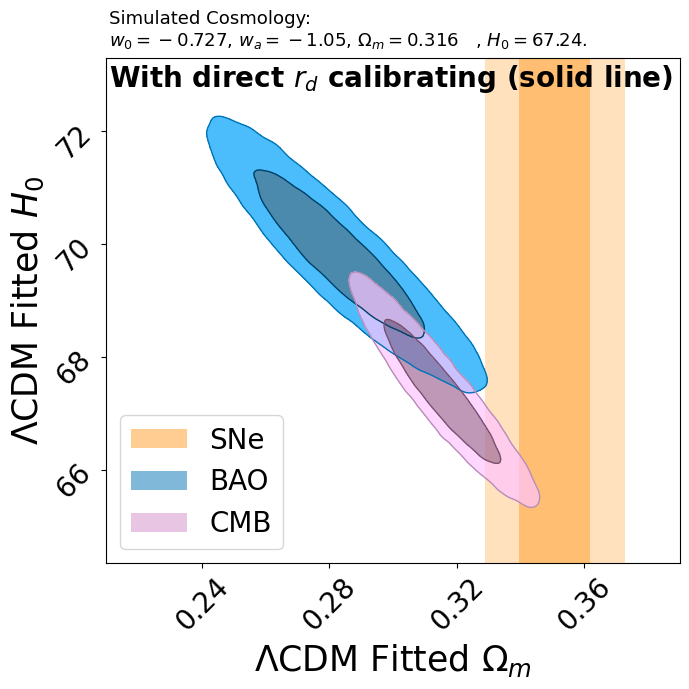

In [19]:
import pickle
import numpy as np

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)
    
with open('data/cmbonly_new_figure1.npy', 'rb') as f:
    cmbonly = np.load(f)
    
with open('data/samples_bao_combined_new_figure1_desi_gaussian.npy', 'rb') as f:
    samples_bao_combined_desi_gaussian = np.load(f)
    
    
import numpy as np
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

samples_bao_combined_df_desi_gaussian = pd.DataFrame(samples_bao_combined_desi_gaussian, columns=["$\Omega_m$", "$H_0$"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])

c = ChainConsumer()

c.add_chain(Chain(samples=samples_bao_combined_df_desi_gaussian, name="BAO like",color='#0173b2'))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like",color='#d38cc6'))

plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=False,
    shade=True,
    bar_shade=True,
    sigmas=[0, 1],
)
c.set_plot_config(plot_config)

# Plot and get the axes
fig = c.plotter.plot(figsize="column")
ax = fig.get_axes()[0]  # Get the main axis

# Define SNe constraints for Omega_m with 1-sigma and 2-sigma bounds
omega_m_sne_mean = mean_value
#omega_m_sne_err = 0.012
omega_m_1sigma_min = one_sigma_lower
omega_m_1sigma_max = one_sigma_upper
omega_m_2sigma_min = two_sigma_lower
omega_m_2sigma_max = two_sigma_upper

h0_min, h0_max = ax.get_ylim()

rect_2sigma = Rectangle(
    (omega_m_2sigma_min, h0_min),
    omega_m_2sigma_max - omega_m_2sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.3,  # Lighter alpha for 2-sigma region
    edgecolor='none'
)
ax.add_patch(rect_2sigma)

rect_1sigma = Rectangle(
    (omega_m_1sigma_min, h0_min),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='SNe',
    edgecolor='none'
)

rect_333sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#0072B2',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='BAO',
    edgecolor='none'
)
rect_444sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#d38cc6',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='CMB',
    edgecolor='none'
)
ax.add_patch(rect_1sigma)
ax.add_patch(rect_333sigma)
ax.add_patch(rect_444sigma)

ax.set_xlim(0.21, 0.39)

ax.legend(loc='lower left', fontsize=20)

ax.set_xlabel("$\Lambda$CDM Fitted $\Omega_m$", fontsize=25)
ax.set_ylabel("$\Lambda$CDM Fitted $H_0$", fontsize=25)
ax.text(
    0.211, 73.5,
    "Simulated Cosmology:\n$w_0=-0.727$, $w_a=-1.05$, $\\Omega_m=0.316$   , $H_0=67.24$.",
    fontsize=13,
    ha='left'
)

ax.text(
    0.211, 73.2, "With direct $r_d$ calibrating (solid line)",  # Adjust (x, y) for positioning
    fontsize=20, color='black', weight='bold', ha='left', va='top'
)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(False)

ax.grid(False)

plt.tight_layout()
fig.savefig('bestw0wa_to_lcdm_desi_gaussian.png', dpi=500)
plt.show()


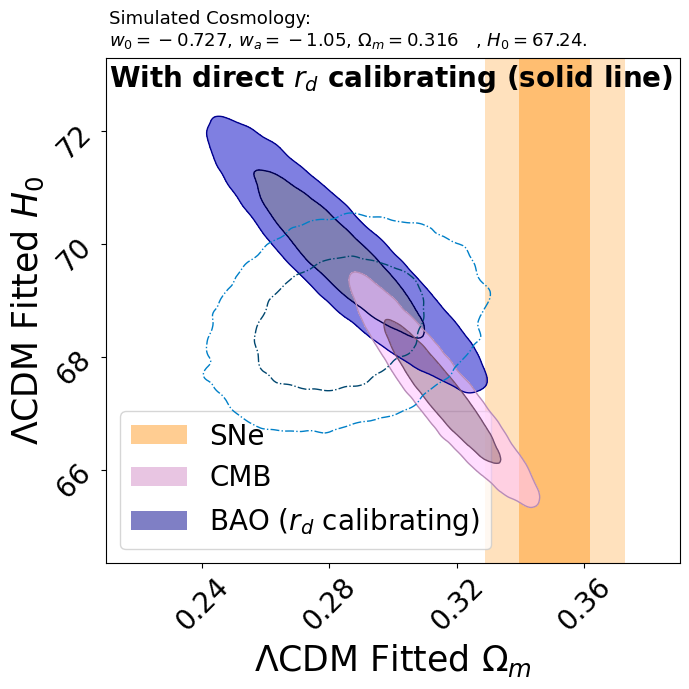

In [21]:
import pickle
import numpy as np

with open('data/samples_sne_combined_with_cov.pkl', 'rb') as f:
    samples_sne_combined_with_cov = pickle.load(f)

with open('data/cmbonly_new_figure1.npy', 'rb') as f:
    cmbonly = np.load(f)

with open('data/samples_bao_combined_new_figure1_desi_gaussian.npy', 'rb') as f:
    samples_bao_combined_desi_gaussian = np.load(f)


import numpy as np
import pandas as pd
from chainconsumer import Chain, ChainConsumer, PlotConfig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

samples_bao_combined_df_desi_gaussian = pd.DataFrame(samples_bao_combined_desi_gaussian, columns=["$\Omega_m$", "$H_0$"])
cmbonly_df = pd.DataFrame(cmbonly, columns=["$\Omega_m$", "$H_0$"])

c = ChainConsumer()

c.add_chain(Chain(samples=samples_bao_combined_df_desi_gaussian, name="BAO like",color='#00008c',shade_alpha=0.5))
c.add_chain(Chain(samples=cmbonly_df, name="CMB like",color='#d38cc6'))
c.add_chain(
    Chain(samples=samples_bao_combined_df, name="BAO dashed", color='#0072B2', linestyle="dashdot", shade=False),
)

plot_config = PlotConfig(
    summary=True,
    bins=1.5,
    smooth=1,
    plot_hists=False,
    shade=True,
    bar_shade=True,
    sigmas=[0, 1],
)
c.set_plot_config(plot_config)

# Plot and get the axes
fig = c.plotter.plot(figsize="column")
ax = fig.get_axes()[0]  # Get the main axis

# Define SNe constraints for Omega_m with 1-sigma and 2-sigma bounds
omega_m_sne_mean = mean_value
#omega_m_sne_err = 0.012
omega_m_1sigma_min = one_sigma_lower
omega_m_1sigma_max = one_sigma_upper
omega_m_2sigma_min = two_sigma_lower
omega_m_2sigma_max = two_sigma_upper

h0_min, h0_max = ax.get_ylim()

rect_2sigma = Rectangle(
    (omega_m_2sigma_min, h0_min),
    omega_m_2sigma_max - omega_m_2sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.3,  # Lighter alpha for 2-sigma region
    edgecolor='none'
)
ax.add_patch(rect_2sigma)

rect_1sigma = Rectangle(
    (omega_m_1sigma_min, h0_min),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#ff9d27',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='SNe',
    edgecolor='none'
)

rect_444sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#d38cc6',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='CMB',
    edgecolor='none'
)

rect_333sigma = Rectangle(
    (0, 0),
    omega_m_1sigma_max - omega_m_1sigma_min,
    h0_max - h0_min,
    facecolor='#00008c',
    alpha=0.5,  # Darker alpha for 1-sigma region
    label='BAO ($r_d$ calibrating)',
    edgecolor='none'
)
ax.add_patch(rect_1sigma)

ax.add_patch(rect_444sigma)
ax.add_patch(rect_333sigma)
ax.set_xlim(0.21, 0.39)

ax.legend(loc='lower left', fontsize=20)

ax.set_xlabel("$\Lambda$CDM Fitted $\Omega_m$", fontsize=25)
ax.set_ylabel("$\Lambda$CDM Fitted $H_0$", fontsize=25)
ax.text(
    0.211, 73.5,
    "Simulated Cosmology:\n$w_0=-0.727$, $w_a=-1.05$, $\\Omega_m=0.316$   , $H_0=67.24$.",
    fontsize=13,
    ha='left'
)

ax.text(
    0.211, 73.2, "With direct $r_d$ calibrating (solid line)",  # Adjust (x, y) for positioning
    fontsize=20, color='black', weight='bold', ha='left', va='top'
)


with open('data/samples_bao_combined_correct_ombh2.npy', 'rb') as f:
    samples_bao_combined = np.load(f)
samples_bao_combined_df = pd.DataFrame(samples_bao_combined, columns=["$\Omega_m$", "$H_0$"])

ax = fig.get_axes()[0]


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(False)


plt.tight_layout()

plt.show()

fig.savefig('bestw0wa_to_lcdm_desi_gaussian.png', dpi=500)
